# TPSL: Short term dip

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.trend import SMAIndicator
import time

In [7]:
# Temporary solution
import sys
sys.path.insert(0, '../..')
import useful_functions as uf

In [9]:
df = pd.read_csv("../../data/BTCUSDT-minute.csv")

In [10]:
df

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,1502942459999,7.564907e+03,3,0.075183,3.203909e+02,7960.540180
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,1502942519999,0.000000e+00,0,0.000000,0.000000e+00,7960.452630
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1502942579999,1.117543e+03,2,0.261074,1.117543e+03,7960.375295
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,1502942639999,5.117185e+01,3,0.012008,5.117185e+01,7960.375295
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,1502942699999,5.999993e+02,1,0.140796,5.999993e+02,7960.375295
...,...,...,...,...,...,...,...,...,...,...,...,...
1988733,2021-06-03 20:24:00,38665.26,38689.56,38655.91,38682.52,14.795718,1622751899999,5.722516e+05,457,5.929895,2.293488e+05,0.000000
1988734,2021-06-03 20:25:00,38682.52,38682.53,38643.07,38649.70,16.778473,1622751959999,6.486770e+05,563,6.614560,2.557099e+05,0.000000
1988735,2021-06-03 20:26:00,38649.69,38682.52,38649.69,38682.52,15.709853,1622752019999,6.074695e+05,566,11.004542,4.255326e+05,0.000000
1988736,2021-06-03 20:27:00,38682.52,38682.69,38640.40,38649.38,23.010205,1622752079999,8.894626e+05,590,7.261787,2.806922e+05,0.000000


## Target Generation

In [11]:
# df = df[1970000:1980000]

In [13]:
def get_target(df, span:int, tp:float, sl:float):
    """
    gets target. must have tp or greater within span and no sl in span
    tp: 1.5
    sl: 2.5
    """
    acc = [] #target column

    for i in range(len(df["close"])):
        close = df.iloc[i].close
        high = df.iloc[i].high
        low = df.iloc[i].low
        
        if i+span < len(df["close"]):
            tp_price = (1+tp/100)*close
            sl_price = (1-sl/100)*close
            high = max(df.iloc[i+1:i+span].high)
            low = min(df.iloc[i+1:i+span].low)
            
            if low<sl_price:
                acc.append(0)
            elif high>tp_price:
                acc.append(1)
            else:
                acc.append(0)
        else:
            acc.append(None)

    return acc
    

In [113]:
def get_target_even_faster(df, span:int, tp:float, sl:float):
    target = []
    sdf = df[['close','high','low']]
    
    i_high = npmax(sdf['high'][0:span])[0]
    i_low = npmin(sdf['low'][0:span])[0]
    
    start_time = time.time()
    
    for i in range(sdf.shape[0]):
        
        #progress tracker
        if i %100000 == 0:
            print('█', end="")
        
        if i+span+1 >= len(sdf['close']): 
            target.append(None)
            continue
            
        close = sdf['close'][i]
        tp_price = (1+tp/100)*close
        sl_price = (1-sl/100)*close
        
        
        if i_high+1 == i:
            i_high = np.argmax(sdf['high'][i+1:i+span])
            high = sdf['high'][i_high]
        elif sdf['high'][i+span] > sdf['high'][i_high]:
            i_high = i+span
            high = sdf['high'][i+span]
        else:
            high = sdf['high'][i_high]
        
        if i_low+1 == i:
            i_low = np.argmin(sdf['low'][i+1:i+span])
            low = sdf['low'][i_low]
        elif sdf['low'][i+span] < sdf['low'][i_low]:
            i_low = i+span
            low = sdf['low'][i+span]
        else:
            low = sdf['low'][i_low]
        
        
        target.append(1 if high>tp_price and low>sl_price else 0)
        
    print(' DONE in %s seconds' % (time.time() - start_time))
    return target

In [114]:
df["target"] = get_target_even_faster(df, span=200, tp=1.5, sl=2.5)

████████████████████ DONE in 59.50685405731201 seconds


In [78]:
df[100000:100200]

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,target,scatter_target
100000,2017-10-25 21:40:00,5679.99,5680.00,5679.98,5679.98,0.607080,1508967659999,3448.212477,8,0.607080,3448.212477,14964.269369,0.0,NaN
100001,2017-10-25 21:41:00,5679.98,5679.99,5679.98,5679.98,0.601831,1508967719999,3418.389845,8,0.601831,3418.389845,14963.397258,0.0,NaN
100002,2017-10-25 21:42:00,5679.98,5682.99,5679.98,5682.99,0.653563,1508967779999,3713.743865,8,0.653563,3713.743865,14963.397258,0.0,NaN
100003,2017-10-25 21:43:00,5682.98,5682.99,5679.98,5679.98,0.475283,1508967839999,2700.862386,6,0.475283,2700.862386,14962.999006,0.0,NaN
100004,2017-10-25 21:44:00,5679.98,5679.98,5679.92,5679.92,0.172023,1508967899999,977.079801,7,0.172023,977.079801,14961.976451,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100195,2017-10-26 00:55:00,5697.98,5697.98,5680.12,5680.13,0.359543,1508979359999,2044.649854,7,0.134438,766.025035,14932.383245,0.0,NaN
100196,2017-10-26 00:56:00,5697.98,5698.99,5680.12,5680.13,0.287321,1508979419999,1634.068795,7,0.113952,649.311354,14932.374550,0.0,NaN
100197,2017-10-26 00:57:00,5680.13,5699.00,5680.12,5680.12,0.360601,1508979479999,2050.844513,8,0.137000,780.763000,14932.274550,0.0,NaN
100198,2017-10-26 00:58:00,5698.98,5699.00,5680.52,5680.55,0.344233,1508979539999,1956.943598,10,0.082041,467.551110,14932.274550,0.0,NaN


## Target Plotting

In [42]:
df["scatter_target"] = list(map(lambda x, c: c if x == 1 else None, df["target"], df["close"]))

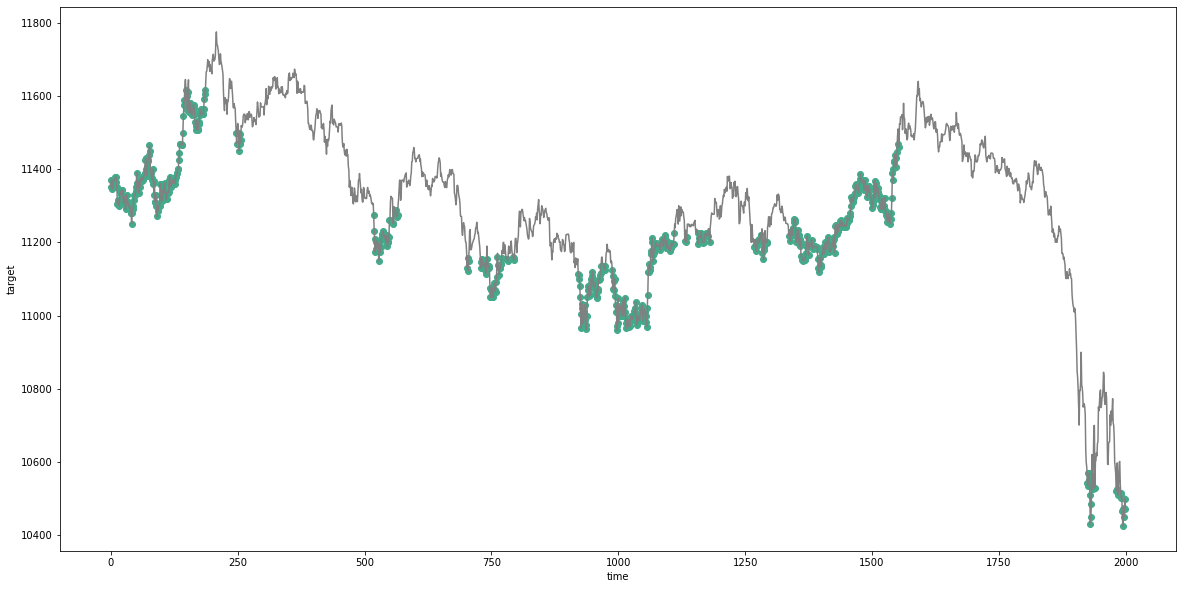

In [117]:
d = df[231000:233000]

fig,ax = plt.subplots(figsize=(20, 10))
ax.scatter(range(len(d)),
           d.scatter_target,
            color="#43aa8b")
# ax.axhline(y=0, color='darkgreen', linestyle='-')
ax.set_xlabel("time")
ax.set_ylabel("target")

# ax.tick_params(labelbottom=False)    
# ax.axes.xaxis.set_visible(False)

# ax2=ax.twinx()
ax.plot(list(d.close),
         color="grey")

# ax.set_ylabel("close")
# fig.legend(["a", "b", "c", "d"])
plt.show()

In [43]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go

## Plotly

In [65]:
# d = df[1000000:]
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=d.index, y=d['close'], name='close'))
# fig.add_trace(go.Scatter(x=d.index, y=d['scatter_target'], name='target'))

# fig.show()

## Evaluation

In [115]:
df.target.value_counts(), df.target.value_counts()[1]/(df.target.value_counts()[0]+df.target.value_counts()[1])

(0.0    1779591
 1.0     208946
 Name: target, dtype: int64,
 0.1050752387307855)

In [92]:
df.to_csv("../data/BTCUSDT-minute-target-tpsl.csv", index=False)

In [66]:
#4

0.0    1988537
Name: target, dtype: int64